# Distillation column example

Process engineers from the site stabilized the yield of a distillation tower but the baseline is now lower than before. There are more than 20 tags (sensors), and it is difficult to understand what process parameters had an impact

Data has been extracted in a CSV for you.

`https://raw.githubusercontent.com/industrial-data/predictor-explainer/main/data/dist_tower_na.csv`  

You can use the URL as a path directly in Pandas.

You can upload it as a file in Google Colab and then use the following path:
`'/content/dist_tower_na.csv'`

The following script includes some EDA (exploratory data analysis) and screening using machine learning.

![364px-Colonne_distillazione.jpg](https://upload.wikimedia.org/wikipedia/commons/thumb/c/cc/Colonne_distillazione.jpg/364px-Colonne_distillazione.jpg)

# Minimal solution (SHAP)

[Industrial data science – a review of machine learning applications for chemical and process industries]()

Max Mowbray,  Mattia Vallerio,  Carlos Perez-Galvan,  Dongda Zhang, 
Antonio Del Rio Chanona and Francisco J. Navarro-Brull

CC-BY (code under BSD-3)

First, we need to load the libraries (tools) we will use.

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from lightgbm.sklearn import LGBMRegressor
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
path_url = 'https://raw.githubusercontent.com/industrial-data/predictor-explainer/main/data/dist_tower_na.csv'

#path_gclab = '/content/dist_tower_na.csv' # needs to be manually upladed first

df = pd.read_csv(path_url, index_col='Date', parse_dates=True)

# Parsing dates can be tricky, here we load the date as an indexed column.

In [3]:
df.head(15) # First 15 rows

,yield,OC1,Temp11,Temp12,PressureC1,TempC1,Temp1,FlowC1,Temp2,Temp3,...,Temp6,Temp7,Temp8,FlowC9,FlowC2,Temp9,Temp10,FlowC3,FlowC4,VapourPressure
Date,,,,,,,,,,,,,,,,,,,,,
2016-08-21,69.400623,3.1033,30.8983,489.9900,215.0627,100.2204,139.9857,432.0636,377.8119,492.1353,...,488.6745,1129.6040,522.4728,86.6133,69.9017,461.2371,513.9653,8.6279,10.5988,32.5026
2016-08-23,66.532666,4.7408,31.9099,480.2888,205.0999,100.2297,131.0470,487.4029,371.3060,482.2100,...,479.5883,1082.9395,516.0140,97.6100,69.6900,450.3000,504.5145,8.7662,10.7560,NaN
2016-08-26,71.102193,4.2925,29.9165,486.6190,205.0304,100.3084,118.2666,437.3516,NaN,488.7266,...,485.6129,1076.9067,514.6193,88.4967,70.5867,458.8101,508.9997,8.5319,10.5737,32.1666
2016-08-29,69.793481,4.4558,30.6229,491.1304,205.2561,95.5766,118.1769,481.8314,378.0028,493.1481,...,489.8262,1078.9117,519.3823,95.3483,70.2167,462.5252,514.1794,8.6260,10.6695,30.4064
2016-08-30,71.489516,3.4600,29.4977,487.6475,205.0883,92.9052,120.7891,NaN,377.8871,490.2486,...,485.5724,1087.4271,508.6756,82.9533,69.6567,NaN,511.0948,8.5939,NaN,30.9238
2016-09-02,NaN,4.5900,29.8406,492.5148,203.8242,82.5759,121.7929,470.8127,374.2480,493.7095,...,491.1167,1081.7068,NaN,93.5633,71.1467,463.8689,514.9607,8.4507,10.4359,30.7826
2016-09-04,69.161052,4.1296,35.5254,478.9996,204.1858,84.9464,120.8903,493.8452,360.8311,480.9020,...,478.1935,1106.8098,514.3184,99.8533,72.6067,445.3766,503.5075,8.4093,10.0906,32.5790
2016-09-06,71.399191,3.7133,31.1274,479.0630,204.3738,86.5622,119.4786,429.0580,365.9138,480.9136,...,477.9389,1090.3263,505.1801,85.8233,72.0667,449.7862,501.0479,8.4414,10.1504,34.5996
2016-09-09,70.125880,3.0900,31.7608,482.6684,204.1163,88.9420,124.8390,414.0616,367.2358,483.9983,...,480.2018,1126.8611,509.5611,82.6411,71.5083,452.2374,505.4058,8.3289,10.2842,34.6329


In [4]:

# Data processing

# LightGBM can handle missing values, except in the Y
df = df.dropna(subset=['yield'])

# No need for fill empties
#dataset = dataset.fillna(method="ffill")

df.head(15)

,yield,OC1,Temp11,Temp12,PressureC1,TempC1,Temp1,FlowC1,Temp2,Temp3,...,Temp6,Temp7,Temp8,FlowC9,FlowC2,Temp9,Temp10,FlowC3,FlowC4,VapourPressure
Date,,,,,,,,,,,,,,,,,,,,,
2016-08-21,69.400623,3.1033,30.8983,489.9900,215.0627,100.2204,139.9857,432.0636,377.8119,492.1353,...,488.6745,1129.6040,522.4728,86.6133,69.9017,461.2371,513.9653,8.6279,10.5988,32.5026
2016-08-23,66.532666,4.7408,31.9099,480.2888,205.0999,100.2297,131.0470,487.4029,371.3060,482.2100,...,479.5883,1082.9395,516.0140,97.6100,69.6900,450.3000,504.5145,8.7662,10.7560,NaN
2016-08-26,71.102193,4.2925,29.9165,486.6190,205.0304,100.3084,118.2666,437.3516,NaN,488.7266,...,485.6129,1076.9067,514.6193,88.4967,70.5867,458.8101,508.9997,8.5319,10.5737,32.1666
2016-08-29,69.793481,4.4558,30.6229,491.1304,205.2561,95.5766,118.1769,481.8314,378.0028,493.1481,...,489.8262,1078.9117,519.3823,95.3483,70.2167,462.5252,514.1794,8.6260,10.6695,30.4064
2016-08-30,71.489516,3.4600,29.4977,487.6475,205.0883,92.9052,120.7891,NaN,377.8871,490.2486,...,485.5724,1087.4271,508.6756,82.9533,69.6567,NaN,511.0948,8.5939,NaN,30.9238
2016-09-04,69.161052,4.1296,35.5254,478.9996,204.1858,84.9464,120.8903,493.8452,360.8311,480.9020,...,478.1935,1106.8098,514.3184,99.8533,72.6067,445.3766,503.5075,8.4093,10.0906,32.5790
2016-09-06,71.399191,3.7133,31.1274,479.0630,204.3738,86.5622,119.4786,429.0580,365.9138,480.9136,...,477.9389,1090.3263,505.1801,85.8233,72.0667,449.7862,501.0479,8.4414,10.1504,34.5996
2016-09-09,70.125880,3.0900,31.7608,482.6684,204.1163,88.9420,124.8390,414.0616,367.2358,483.9983,...,480.2018,1126.8611,509.5611,82.6411,71.5083,452.2374,505.4058,8.3289,10.2842,34.6329
2016-09-11,69.726319,4.6217,32.3697,483.9492,204.1510,85.8770,121.6020,505.6681,368.3813,485.1037,...,482.2794,1087.4791,521.9056,99.9829,71.4267,452.7339,506.4996,8.5193,10.4781,31.8927


<Axes: xlabel='Date'>

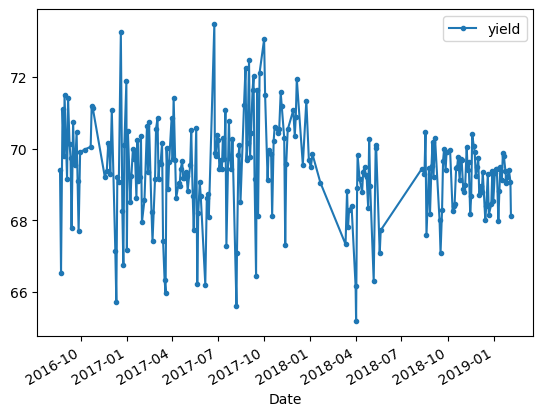

In [5]:
y = df['yield'].copy()
X = df.copy()
del X['yield']

y.head()

y.plot(style='.-', legend=True)

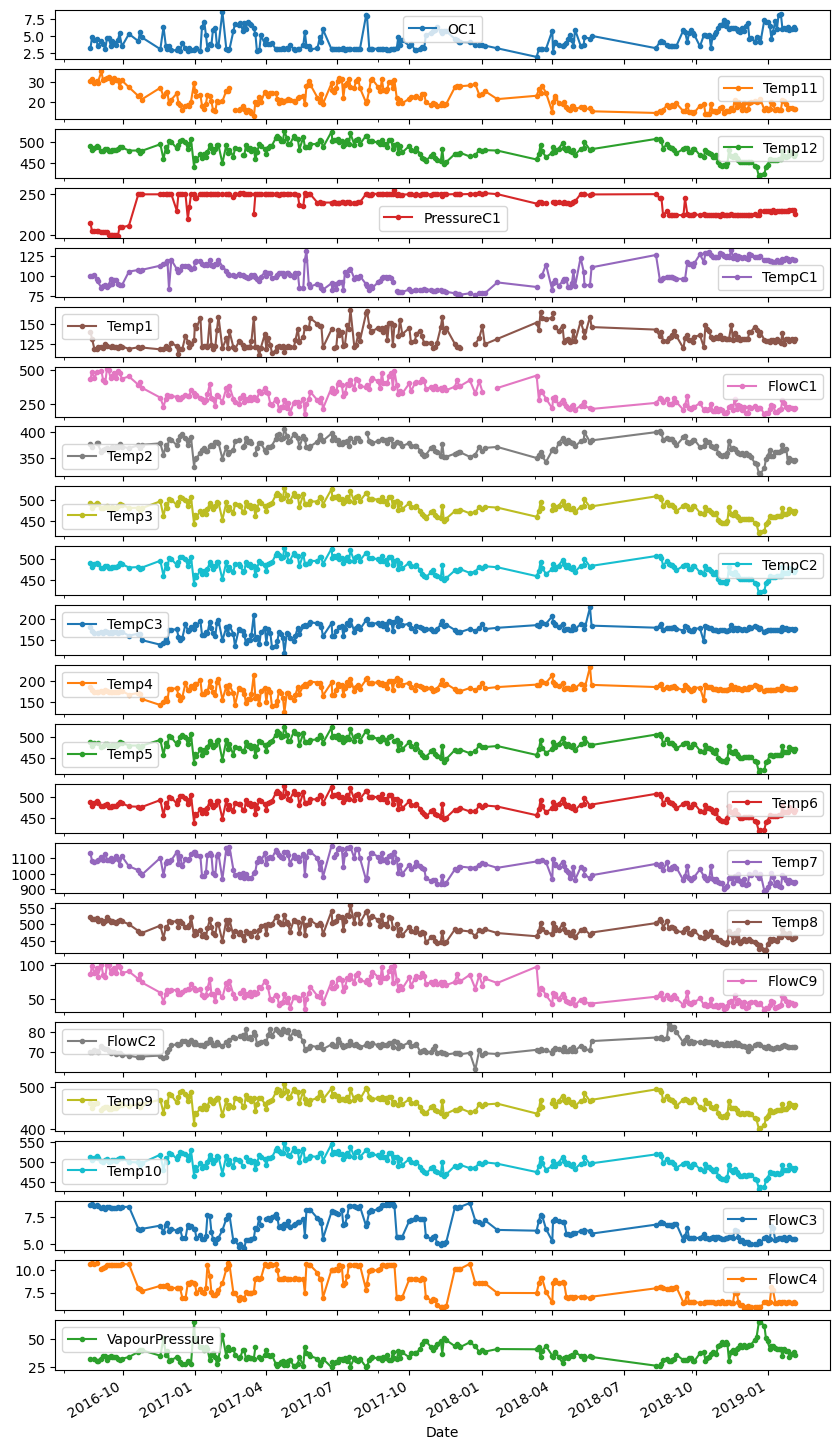

In [6]:
X.plot(figsize=(10,20), style='.-', subplots=True);

<Axes: xlabel='Date'>

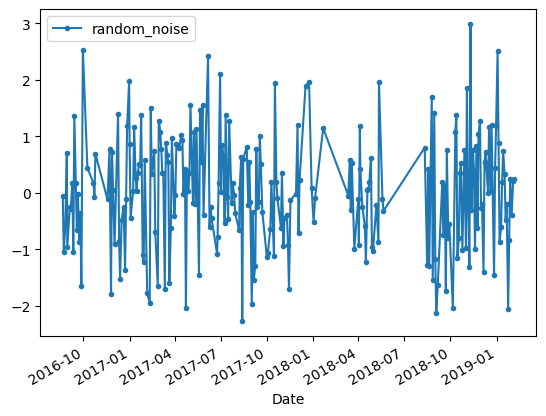

In [7]:
# Feature engineering
# for column in X:
#   new_column_name =  "diff(" + str(column) + ")"
#   try:
#     X[new_column_name] = X[column].diff()
#   except:
#     print("Problems with", new_column_name)

#Adding noise

X["random_noise"] =  np.random.normal(0,1,len(X))

X["random_noise"].plot(style='.-', legend=True)

In [8]:
# Data modeling

try:
    del(X['Date'])
    del(y['Date'])
except:
    print("Date column not in X or Y");
    
n_trees = 100;
lgbm = LGBMRegressor(n_estimators = n_trees) #keeping default for the other parameters
y_model = lgbm.fit(X,y)

LGBMRegressor.score

Date column not in X or Y


<function sklearn.base.RegressorMixin.score(self, X, y, sample_weight=None)>

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


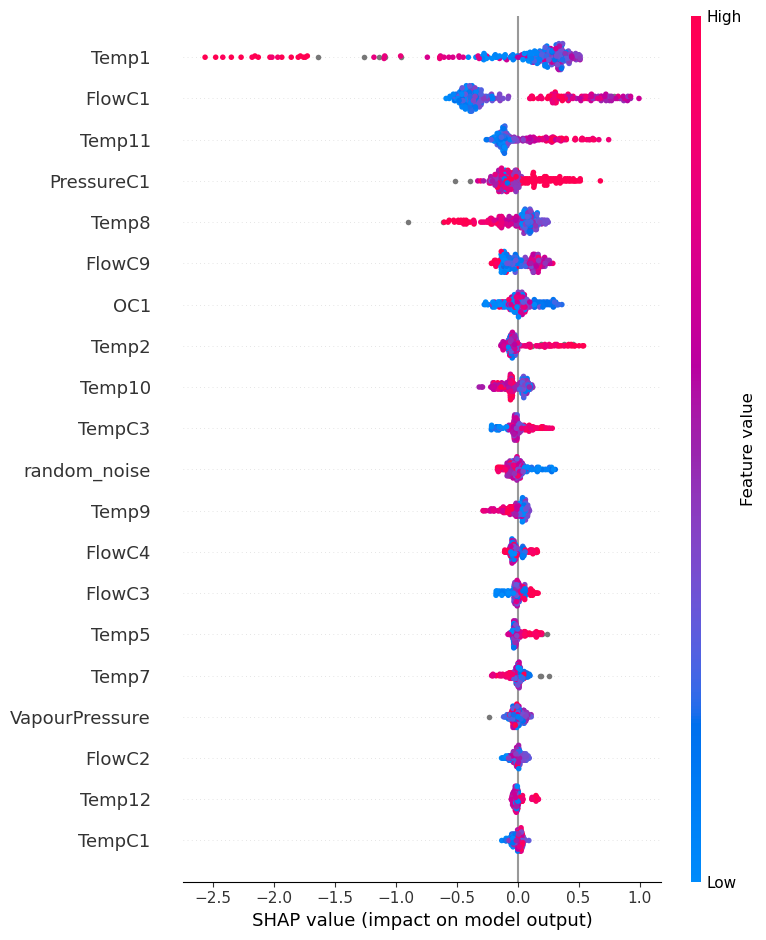

In [9]:

explainer_lgbm = shap.TreeExplainer(lgbm)

shap_values_lgbm = explainer_lgbm.shap_values(X)

# Plotting
shap.summary_plot(shap_values_lgbm, X)

plt.show()